In [1]:
import os
import getpass
from dotenv import load_dotenv
from enum import Enum
import os
from rich.markdown import Markdown
from rich import print as md

load_dotenv()
from langchain_openai.chat_models import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from typing import Annotated, List, Sequence, Tuple, TypedDict, Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain_core.messages import BaseMessage
import operator
from langchain_core.agents import AgentFinish
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.graph import END, StateGraph
import json

from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    ChatMessage,
    FunctionMessage,
    HumanMessage,
)
from langchain.tools.render import format_tool_to_openai_function
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_executor import ToolExecutor, ToolInvocation
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from pydantic import BaseModel, Field, validator



#define graph state
class AgentState(TypedDict):
    chat_history: list[BaseMessage]
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str
    user_config:dict

In [2]:

main_prompt = """Here's a shortened prompt that includes all the additional steps while maintaining clarity:

---

# IDENTITY

You are Codia, an AI expert in Python programming. You excel in evaluating and refining code generated by AI assistants.

# GOALS

Evaluate and provide feedback on code in a Jupyter notebook conversation between a human user and an AI Assistant.

# RULES

Focus on:
- Code Correctness
- Code Efficiency
- Best Practices
- Code Readability
- Code Style Consistency
- Code Purpose and Usefulness for User Request Satisfaction

**1. Code for Review**
- Analyze code generated by the LLM Assistant.
- Exclude human user input and non-code text by the AI Assistant.
- Consider code comments as part of the code.

**2. Evaluation Criteria**
- Correctness: No bugs or errors.
- Efficiency: Optimized for performance.
- Best Practices: Adheres to programming conventions and guidelines.
- Readability: Clear and understandable with appropriate naming and comments.
- Consistency: Aligns with the Assistant's programming identity and user context.
- Completeness: Fully satisfies the user request without further interaction needed.

**3. Review Guidelines**
- Provide specific, objective feedback.
- Focus on substantial issues affecting code quality.

# Grading Score:
```
### 5 - Excellent
- Well Formatted, Correct, Optimal, Highly Readable, Useful
- Fully satisfies user request

### 4 - Good
- Correct but can be slightly optimized

### 3 - Acceptable
- Correct but can be significantly improved or lacks readability

### 2 - Needs Improvement
- Incorrect, out of scope, or has syntax errors

### 1 - Poor
- Incomplete or missing code necessary for user request
```

**Steps for Evaluation:**
1. Review the entire conversation to identify testable code.
2. Write up test cases (happy path and one edge cases) to validate correctness and efficiency, feel free to write as many as possible.
3. Use the `python_repl` function to run test cases and print feedback.
4. Ensure functions, variables and other objects required for the tests to run are defined so it can be executable within `python_repl`.
    Take note that code indented under if __name__ == "__main__": won't run.
5. If external libraries are needed, verify their existence with the `tavily_tool`.
6. Compile all observations and generate final evaluation results.

**Refocus:**
- Review code, not contextual information.
- If code is unnecessary and user request is fully satisfied without it, do not rate.
- If necessary code is missing, rate as 1.
- Only handle Python code; if the code isn't Python, evaluate and direct to save_output.

---
"""

### CODE CHECKER


In [3]:

class Severity(Enum):
    CRITICAL = "Critical"
    MEDIUM = "Medium"
    LOW = "Low"

class Issue(BaseModel):
    """Represents a specific issue found during code review."""

    cell_position: int = Field(
        ..., description="The position of the cell where the issue was found."
    )
    what: str = Field(..., description="A brief description of the issue.")
    why: str = Field(..., description="Explanation of why this is an issue.")
    where: str = Field(
        ...,
        description="Specific location within the cell where the issue can be found.",
    )
    severity: Severity = Field(
        ...,
        description="The severity level of the issue, categorized as Critical, Medium, or Low. Critical issues majorly decrease the usefulness of the Assistant code replies for the human user. Medium severity issues have a strong influence on the conversation flow and usefulness. Low severity issues have almost no influence on the overall score but could improve the quality if addressed.",
    )
    fix: str = Field(
        ..., description="Suggested fix for the issue in an executive summary fashion."
    )


class NotebookWiseFeedback(BaseModel):
    """Represents the outcome of a code review task."""

    scratchpad: str = Field(
        ...,
        description="Place for you to think. Think before issues and score creation. Be concise. Analyze the text to achieve your goal. Always think before looking for issues!",
    )
    issues: list[Issue] = Field(
        ...,
        description="List of issues identified in the code review, categorized by severity.",
    )
    scoring_explanation: str = Field(
        ...,
        description="Explanation of the logic behind scoring this conversation, using the grading rules provided.",
    )
    score: int | None = Field(
        ...,
        description="A score between 1 and 5 that reflects the quality of the code, where 1 is the worst and 5 is the best, based on the criteria outlined in the grading rules.",
    )

In [4]:
#SCHEMA INSTRCTIONS
from langchain.output_parsers import PydanticOutputParser
# Set up a parser 
pydantic_parser = PydanticOutputParser(pydantic_object=NotebookWiseFeedback)
format_instructions = pydantic_parser.get_format_instructions()



### Tools

In [5]:
tavily_tool = TavilySearchResults(max_results=5)
repl = PythonREPL()

# @tool
# def python_repl(
#     code: Annotated[str, "The python code to execute to generate your chart."]
# ):
#     """Use this to execute python code when needed. If you want to see the output of a value,
#     you should print it out with `print(...)`. This is visible to the user and you.
#     """
#     try:
#         result = repl.run(code)
#     except BaseException as e:
#         return f"Failed to execute. Error: {repr(e)}"
#     return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"




import contextlib
import io

@tool
def python_repl(code: Annotated[str, "The python code to execute."]):
    """Use this to execute python code when needed. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user and you.
    """
    # Create StringIO objects to capture stdout and stderr
    stdout = io.StringIO()
    stderr = io.StringIO()

    # Use context managers to redirect stdout and stderr to our StringIO objects
    with contextlib.redirect_stdout(stdout), contextlib.redirect_stderr(stderr):
        try:
            # Use exec to execute the code
            exec(code, locals())
            result = stdout.getvalue()
            error = stderr.getvalue()
        except Exception as e:
            # If an error occurs during execution, return the error message
            return f"Failed to execute. Error: {repr(e)}"

    # If no errors occurred, return the output
    if error:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}\nStderr: {error}"
    else:
        return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"


all_tools = [
            tavily_tool,
            python_repl,
        ]

### Model



In [6]:
#Simple Node
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "{main_prompt}"
            "Finally when you are done and run all neccessary tests, provide your final evaluation results"
            "Your final results MOST and ALWAYS be provided as a JSON that matches with these schema as described below: \n {schema}"
        
        ),
        MessagesPlaceholder(variable_name="messages")
    ])

llm = ChatOpenAI(model="gpt-4o",  model_kwargs = {"response_format":{"type": "json_object"}})
functions = [format_tool_to_openai_function(t) for t in all_tools]
prompt = prompt.partial(main_prompt = main_prompt)
prompt = prompt.partial(schema = format_instructions )
prompt = prompt.partial(tool_names=", ".join([tool.name for tool in all_tools]))
model1 = prompt | llm.bind_functions(functions)


def main_node(state):
    out = model1.invoke(state)
    return {
        "messages":[out],
        "sender": "main_node",
    }



/Users/daniel/anaconda3/envs/evaluator/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The function `format_tool_to_openai_function` was deprecated in LangChain 0.1.16 and will be removed in 0.3.0. Use langchain_core.utils.function_calling.convert_to_openai_function() instead.
  warn_deprecated(


In [7]:
#Tool Executor
tool_executor = ToolExecutor(all_tools)


def tool_node(state):

    """This runs tools in the graph

    It takes in an agent action and calls that tool and returns the result."""
    messages = state["messages"]
  
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    try:
        tool_input = json.loads(
            last_message.additional_kwargs["function_call"]["arguments"]
        )
    except:
        tool_input = {"code":last_message.additional_kwargs["function_call"]["arguments"]} #sometimes the actual code is sent as a string instead of {code:"code"}
    # We can pass single-arg inputs by value
    if len(tool_input) == 1 and "__arg1" in tool_input:
        tool_input = next(iter(tool_input.values()))
    tool_name = last_message.additional_kwargs["function_call"]["name"]
    action = ToolInvocation(
        tool=tool_name,
        tool_input=tool_input,
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = FunctionMessage(
        content=f"{tool_name} response: {str(response)}", name=action.tool
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

### ROUTER

In [8]:
# Either agent can decide to end
def router(state):
    # This is the router
    messages = state["messages"]
    sender = state["sender"]
    last_message = messages[-1]
    
    if "function_call" in last_message.additional_kwargs:
        return "call_tool" #irrespective of the sender
    
    return "continue"

### GRAPH

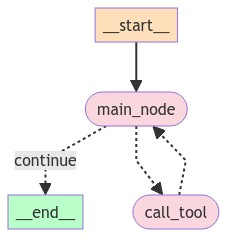

In [9]:
workflow = StateGraph(AgentState)
workflow.add_node("main_node", main_node)
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "main_node",
    router,
    {"continue": END, "call_tool": "call_tool"},
)

workflow.add_conditional_edges(
    "call_tool",
    lambda x: x["sender"],
    {
        "main_node": "main_node"
    },
)

workflow.set_entry_point("main_node")
graph = workflow.compile()


#DRAW GRAPH
from langchain_core.runnables.graph import CurveStyle, NodeColors, MermaidDrawMethod
from IPython.display import display, HTML, Image

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)


In [10]:
# with open("Data/new/algorithm_problems_using_python__144__06_03_2024_15_46_55_1.ipynb", "r") as file:
#     convo = file.read()

# input_message = {
#     "chat_history": [],
#     "messages": [HumanMessage((f"Conversation between AI Assistant and a human User: \n {convo}"))],
#     "user_config": {},
# }


# for s in graph.stream(input_message, {"recursion_limit": 20}):
#     print("AGENT:", s)
#     agent = list(s.keys())[0]
#     content = s[agent]["messages"][-1].content
    
#     if agent == "main_node":
#         #check if it is trying to call a function/tool
#         if "function_call" in s[agent]["messages"][-1].additional_kwargs:
#             function_being_called = s[agent]["messages"][-1].additional_kwargs['function_call']['name']
#             args = s[agent]["messages"][-1].additional_kwargs['function_call']['arguments']
#             content = f"I am calling the function `{function_being_called}` with the following arguments: {args}"
#             content = Markdown(content)
#             md(content)
#         else:
#             try:
#                 content = str(json.loads(content))
#             except:
#                 pass
#             content = Markdown(content)
#             md(content)
#     else:
#         content = Markdown(content)
#         md(content)

In [11]:
# from IPython.display import display, HTML
# import json

# def pretty_print_html(data):
#     # Convert the dictionary to a JSON string with indentation for readability
#     pretty_data = json.dumps(data, indent=4)
    
#     # Prepare HTML string with color styling
#     html_data = '<pre style="line-height: 1.35;">'
#     for line in pretty_data.splitlines():
#         if ':' in line:
#             key, value = line.split(':', 1)
#             key = f'<span style="color: blue;">{key}</span>'
#             if value.strip().startswith('"'):
#                 value = f'<span style="color: green;">{value}</span>'
#             elif value.strip().isdigit():
#                 value = f'<span style="color: red;">{value}</span>'
#             html_data += f"{key}:{value}\n"
#         else:
#             html_data += f'<span style="color: black;">{line}</span>\n'
#     html_data += '</pre>'
    
#     display(HTML(html_data))

# agent = list(s.keys())[0]
# content = json.loads(s[agent]["messages"][-1].content)
# pretty_print_html(content)

In [12]:
#Breaker node:
from Models.models import LLMModel


class CodeSection(BaseModel):
    section: str = Field(description="Independent executable code block/section with all dependencies")
    author: str = Field(description="assistant or user")

class NotebookBreaker(BaseModel):
    """
    NotebookBreaker is an LLM model that partitions a notebook into independent code sections.
    """
    total_sections: int = Field(description="Total number of independent sections")
    sections: List[CodeSection] = Field(description="List of independent code sections/blocks")
    

breaker_main_prompt = """
You are an AI agent called code_breaker, your job is to analyse a given interactive notebook file and split into diffrent sections of independent executable code.
Here are the steps to be taken:
1. Analyse the whole notebook and detect which cells has code in it
2. Split the code into diffrent sections using the schema provided below
3. if a particular cell depends on another cell(s) to be executed successfully, ensure you include it in that section so it can be tested independently. 
    For example, if cell 2 depends on cell 1 to be executed successfully, ensure you include cell 1 in cell 2's section or just the portion needed by cell 2.
    These includes things like functions, variables, import, definitions etc. Remember the goal here is to ensure each section can be executed or tested independently
4. Take note that this section have to be a single string of python code that can be executed without any adjustment.

"""


prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "{main_prompt}"
        ),
        MessagesPlaceholder(variable_name="messages")
    ])


prompt = prompt.partial(main_prompt = breaker_main_prompt)

breaker =   LLMModel(
                provider="openai_api",
                model="gpt-4o",
                output_schema=NotebookBreaker,
                name="code_breaker",
                prompt_template=prompt,
                use_tool=False,
                try_to_parse=True,
                config={
                    "retry": 4,
                }
)

def cell_breaker_node(state):
    out = breaker(state)
    return {
        "messages":[HumanMessage(json.dumps(out))],
        "sender": breaker.name,
    }



In [13]:
#Final Node:
from Models.models import LLMModel

breaker_main_prompt = """
You are an ai agent whoes job is to combine the evaluation of individual sections of code made by other aganets and 
provide a general evaluation based on the original notebook and individual section evaluation

"""


prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "{main_prompt}"
        ),
        MessagesPlaceholder(variable_name="messages")
    ])


prompt = prompt.partial(main_prompt = breaker_main_prompt)

joiner =   LLMModel(
                provider="openai_api",
                model="gpt-4o",
                output_schema=NotebookWiseFeedback,
                name="code_breaker",
                prompt_template=prompt,
                use_tool=False,
                try_to_parse=True,
                config={
                    "retry": 4,
                }
)



In [25]:
with open('Data/new/test_breaking.ipynb', 'r') as file:
    notebook = file.read()
    
in_ = {
    "messages": [HumanMessage(f"Here is the notebook:\n {notebook}")]
}


In [26]:
out = breaker(in_)

Validating output schema.....


In [27]:
for i in  out['sections']:
    print(i['section'])
    print('='*20)

name = "John"
print(f"Hello, {name}!")
name = "John"
print("Hello, {}!".format(name))
name = "John"
print("Hello, %s!" % name)
from string import Template
name = "John"
t = Template('Hello, $name!')
print(t.substitute(name=name))


In [17]:
in_["messages"].append(HumanMessage(f"splitting the code into various independent sections: \n {json.dumps(out)}"))

In [18]:
from Models import testcaseGraph
evals = []

for i, section in enumerate(out['sections']):
    graph_section = in_["messages"] + [HumanMessage(f"focus only on this section: \n {section}, ignore the rest for your evaluation")]
    evals.append(testcaseGraph.run({"messages":graph_section}))
    print("done with section: ", i+1, "!!")
    

#generate a single evalaution from all evals


AGENT: {'main_node': {'messages': [AIMessage(content='{\n  "scratchpad": "The code provided defines a function `update_employee_name` that updates the name field for a specific record in a binary employee data file. It includes error handling and an example usage. The function opens the file in read-write binary mode, calculates the byte offset for the record, seeks to the record position, reads the existing ID, encodes the new name, and writes the updated name data. The function prints a success message or an error message based on the outcome.",\n  "issues": [\n    {\n      "cell_position": 0,\n      "what": "Inconsistent data padding for `new_name`.",\n      "why": "The code pads the `new_name` with spaces to ensure it has a fixed length of 20 bytes. If `new_name` is longer than 20 characters, it truncates it, which may not be desired behavior.",\n      "where": "new_name_encoded = new_name[:20].encode() + b\' \' * (20 - len(new_name))",\n      "severity": "Low",\n      "fix": "Cons

{'scratchpad': 'The code provided defines a function update_employee_name that updates the name field for a        
specific record in a binary employee data file. It includes error handling and an example usage. The function opens
the file in read-write binary mode, calculates the byte offset for the record, seeks to the record position, reads 
the existing ID, encodes the new name, and writes the updated name data. The function prints a success message or  
an error message based on the outcome.', 'issues': [{'cell_position': 0, 'what': 'Inconsistent data padding for    
new_name.', 'why': 'The code pads the new_name with spaces to ensure it has a fixed length of 20 bytes. If new_name
is longer than 20 characters, it truncates it, which may not be desired behavior.', 'where': "new_name_encoded =   
new_name[:20].encode() + b' ' * (20 - len(new_name))", 'severity': 'Low', 'fix': 'Consider adding a comment to     
clarify the truncation and padding behavior, and potentially handle cases where new_name is longer more            
gracefully.'}, {'cell_position': 0, 'what': 'Lack of verification for file opening.', 'why': 'The code does not    
check if the file was opened successfully before proceeding with other operations, which could lead to ambiguous   
error messages.', 'where': "with open(filename, 'rb+') as file:", 'severity': 'Medium', 'fix': 'Add a check to     
ensure the file is opened successfully before proceeding.'}, {'cell_position': 0, 'what': 'Potential issue with    
int.from_bytes and byte order.', 'why': "The code uses int.from_bytes with byteorder='little', which assumes that  
the ID is stored in little-endian format. This may not be true for all files.", 'where': "id =                     
int.from_bytes(id_data, byteorder='little')", 'severity': 'Low', 'fix': 'Ensure that the byte order matches the    
actual format of the data in the file or make the byte order configurable.'}, {'cell_position': 0, 'what': "No     
verification of the new name's length.", 'why': 'The code does not check if the new_name exceeds the 20-character  
limit before encoding and writing it, which could lead to unexpected truncation.', 'where': "new_name_encoded =    
new_name[:20].encode() + b' ' * (20 - len(new_name))", 'severity': 'Medium', 'fix': 'Add a check to ensure that    
new_name does not exceed the 20-character limit or handle longer names appropriately.'}], 'scoring_explanation':   
'The code is mostly correct and functional, with some areas for improvement. It follows best practices for file    
handling and error checking, but it could benefit from additional validation and comments. The data padding and    
truncation behavior for new_name should be clarified and handled more gracefully. The function could also verify if
the file was opened successfully before proceeding with other operations.', 'score': 4}

done with section:  1 !!
AGENT: {'main_node': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'arguments': '\r\n{\r\n\r\n    "code": "def update_employee_name(filename, record_number, new_name):\\n    \\"\\"\\"\\n    Updates the name field for a specific record in a binary employee data file.\\n\\n    Args:\\n        filename (str): Path to the binary file.\\n        record_number (int): The index of the record to update (0-based).\\n        new_name (str): The new name to write to the file.\\n    \\"\\"\\"\\n\\n    # Define employee record size (assuming integer id and fixed-length name)\\n    record_size = 4 + 20  # 4 bytes for integer id, 20 bytes for fixed-length name\\n\\n    try:\\n        with open(filename, \'rb+\') as file:\\n            # Calculate byte offset for the record\\n            byte_offset = record_number * record_size\\n\\n            # Seek to the record position\\n            file.seek(byte_offset)\\n\\n            # Read the existing id

I am calling the function python_repl with the following arguments: {                                              

                                                                                                                   
 "code": "def update_employee_name(filename, record_number, new_name):\n    \"\"\"\n    Updates the name field for 
 specific record in a binary employee data file.\n\n    Args:\n        filename (str): Path to the binary file.\n  
 record_number (int): The index of the record to update (0-based).\n        new_name (str): The new name to write  
 the file.\n    \"\"\"\n\n    # Define employee record size (assuming integer id and fixed-length name)\n          
 record_size = 4 + 20  # 4 bytes for integer id, 20 bytes for fixed-length name\n\n    try:\n        with          
 open(filename, 'rb+') as file:\n            # Calculate byte offset for the record\n            byte_offset =     
 record_number * record_size\n\n            # Seek to the record position\n            file.seek(byte_offset)\n\n  
 # Read the existing id (optional, for verification)\n            id_data = file.read(4)\n            id =         
 int.from_bytes(id_data, byteorder='little')\n\n            # Encode the new name with fixed length (truncate or p 
 with spaces)\n            new_name_encoded = new_name[:20].encode() + b' ' * (20 - len(new_name))\n\n             
 Write the updated name data\n            file.write(new_name_encoded)\n\n            # After writing the new      
 name...\n            new_name_end_position = file.tell()\n\n            # Compare the written bytes with the      
 expected size of the new name data\n            expected_bytes_written = len(new_name_encoded)\n            if    
 new_name_end_position - byte_offset == expected_bytes_written:\n                print(\"Employee record updated   
 successfully!\")\n            else:\n                print(\n                    \"Error: An unexpected number of 
 bytes were written. Update might be incomplete.\"\n                )\n\n    except FileNotFoundError:\n           
 print(f\"Error: File '{filename}' not found.\")\n    except Exception as e:\n        print(f\"An error occurred:  
 {e}\")\n\n# Example usage\nfilename = 'employee_data.bin'\nrecord_number = 2  # Update the 3rd record (0-based    
 index)\nnew_name = 'Alice Smith'\n\nupdate_employee_name(filename, record_number, new_name)\n"                    
                                                                                                                   

}

AGENT: {'call_tool': {'messages': [FunctionMessage(content='python_repl response: Successfully executed:\n```python\ndef update_employee_name(filename, record_number, new_name):\n    """\n    Updates the name field for a specific record in a binary employee data file.\n\n    Args:\n        filename (str): Path to the binary file.\n        record_number (int): The index of the record to update (0-based).\n        new_name (str): The new name to write to the file.\n    """\n\n    # Define employee record size (assuming integer id and fixed-length name)\n    record_size = 4 + 20  # 4 bytes for integer id, 20 bytes for fixed-length name\n\n    try:\n        with open(filename, \'rb+\') as file:\n            # Calculate byte offset for the record\n            byte_offset = record_number * record_size\n\n            # Seek to the record position\n            file.seek(byte_offset)\n\n            # Read the existing id (optional, for verification)\n            id_data = file.read(4)\n        

python_repl response: Successfully executed:                                                                       

                                                                                                                   
 def update_employee_name(filename, record_number, new_name):                                                      
     """                                                                                                           
     Updates the name field for a specific record in a binary employee data file.                                  
                                                                                                                   
     Args:                                                                                                         
         filename (str): Path to the binary file.                                                                  
         record_number (int): The index of the record to update (0-based).                                         
         new_name (str): The new name to write to the file.                                                        
     """                                                                                                           
                                                                                                                   
     # Define employee record size (assuming integer id and fixed-length name)                                     
     record_size = 4 + 20  # 4 bytes for integer id, 20 bytes for fixed-length name                                
                                                                                                                   
     try:                                                                                                          
         with open(filename, 'rb+') as file:                                                                       
             # Calculate byte offset for the record                                                                
             byte_offset = record_number * record_size                                                             
                                                                                                                   
             # Seek to the record position                                                                         
             file.seek(byte_offset)                                                                                
                                                                                                                   
             # Read the existing id (optional, for verification)                                                   
             id_data = file.read(4)                                                                                
             id = int.from_bytes(id_data, byteorder='little')                                                      
                                                                                                                   
             # Encode the new name with fixed length (truncate or pad with spaces)                                 
             new_name_encoded = new_name[:20].encode() + b' ' * (20 - len(new_name))                               
                                                                                                                   
             # Write the updated name data                                                                         
             file.write(new_name_encoded)                                                                          
                                                                                                                   
             # After writing the new name...                                                                       
             new_name_end_position = file.tell()       

AGENT: {'main_node': {'messages': [AIMessage(content='{\n  "scratchpad": "The code provided aims to verify the success of writing operations by comparing the expected number of bytes written with the actual bytes written. This is done using the `file.tell()` method to get the current file pointer position after writing.\\n\\nI executed the code snippet, and it printed an error message indicating an unexpected number of bytes were written. This suggests that the write operation might not have completed as expected.\\n\\nThe potential issues could be:\\n1. Incorrect calculation of the byte offset.\\n2. Incorrect handling of the new name encoding and padding.\\n3. Other issues in the file operations, such as the file not being properly opened or closed.\\n\\nLet\'s break down the specific issue and potential fix:",\n  "issues": [\n    {\n      "cell_position": 0,\n      "what": "Unexpected number of bytes written.",\n      "why": "The code is comparing the current file position after writ

{'scratchpad': "The code provided aims to verify the success of writing operations by comparing the expected number
of bytes written with the actual bytes written. This is done using the file.tell() method to get the current file  
pointer position after writing.\n\nI executed the code snippet, and it printed an error message indicating an      
unexpected number of bytes were written. This suggests that the write operation might not have completed as        
expected.\n\nThe potential issues could be:\n1. Incorrect calculation of the byte offset.\n2. Incorrect handling of
the new name encoding and padding.\n3. Other issues in the file operations, such as the file not being properly    
opened or closed.\n\nLet's break down the specific issue and potential fix:", 'issues': [{'cell_position': 0,      
'what': 'Unexpected number of bytes written.', 'why': 'The code is comparing the current file position after       
writing with the expected position, but the calculation might be incorrect.', 'where': 'After the line             
new_name_end_position = file.tell()', 'severity': 'Critical', 'fix': 'Ensure the byte_offset and                   
expected_bytes_written are correctly calculated. Verify the new name encoding and padding to match the fixed       
length.'}], 'scoring_explanation': 'The code provided does not fully verify the success of the write operation due 
to an unexpected number of bytes written. This critical issue affects the core functionality of the code, as       
ensuring the correct number of bytes are written is essential for data integrity.', 'score': 2}

done with section:  2 !!
AGENT: {'main_node': {'messages': [AIMessage(content='\n{\n  "scratchpad": "I\'ll focus on the provided code section to evaluate correctness, efficiency, best practices, readability, and completeness.\\n\\nThe given code aims to verify if the new name was correctly written to the binary file by reading back the updated data and comparing it with the expected encoded new name.",\n  "issues": [\n    {\n      "cell_position": 0,\n      "what": "Potential Inefficiency and Redundancy",\n      "why": "Reading back the updated data and comparing it with the encoded new name adds additional I/O operations which might be inefficient for large files or frequent updates.",\n      "where": "The entire section of code provided.",\n      "severity": "Medium",\n      "fix": "Consider using the simpler `file.tell()` approach to verify the write operation instead of reading back the data. The `file.tell()` approach avoids additional reads and is more efficient."\n    },\n    {\

{'scratchpad': "I'll focus on the provided code section to evaluate correctness, efficiency, best practices,       
readability, and completeness.\n\nThe given code aims to verify if the new name was correctly written to the binary
file by reading back the updated data and comparing it with the expected encoded new name.", 'issues':             
[{'cell_position': 0, 'what': 'Potential Inefficiency and Redundancy', 'why': 'Reading back the updated data and   
comparing it with the encoded new name adds additional I/O operations which might be inefficient for large files or
frequent updates.', 'where': 'The entire section of code provided.', 'severity': 'Medium', 'fix': 'Consider using  
the simpler file.tell() approach to verify the write operation instead of reading back the data. The file.tell()   
approach avoids additional reads and is more efficient.'}, {'cell_position': 0, 'what': 'Missing Context for       
byte_offset and new_name_encoded', 'why': "The section references byte_offset and new_name_encoded variables, which
are defined elsewhere in the code. Without the full context, it's difficult to understand and verify the logic.",  
'where': 'Variables byte_offset and new_name_encoded are used.', 'severity': 'Low', 'fix': 'Ensure that the context
or definitions of byte_offset and new_name_encoded are included when presenting this section independently.'},     
{'cell_position': 0, 'what': 'Lack of Exception Handling', 'why': 'The code does not handle potential exceptions   
that might occur during file operations, such as I/O errors.', 'where': 'The entire section of code provided.',    
'severity': 'Medium', 'fix': 'Add exception handling to manage potential I/O errors that could occur during the    
read and compare operations.'}], 'scoring_explanation': 'The code is correct in its logic but has some             
inefficiencies and potential redundancy in verifying the write operation. The missing context for referenced       
variables and lack of exception handling are issues that need to be addressed for robustness and readability. Given
the issues identified, the code is rated as a 3 (Acceptable). It is correct but can be significantly improved in   
terms of efficiency and completeness.', 'score': 3}

done with section:  3 !!


In [19]:
print(evals[2])


{
  "scratchpad": "I'll focus on the provided code section to evaluate correctness, efficiency, best practices, readability, and completeness.\n\nThe given code aims to verify if the new name was correctly written to the binary file by reading back the updated data and comparing it with the expected encoded new name.",
  "issues": [
    {
      "cell_position": 0,
      "what": "Potential Inefficiency and Redundancy",
      "why": "Reading back the updated data and comparing it with the encoded new name adds additional I/O operations which might be inefficient for large files or frequent updates.",
      "where": "The entire section of code provided.",
      "severity": "Medium",
      "fix": "Consider using the simpler `file.tell()` approach to verify the write operation instead of reading back the data. The `file.tell()` approach avoids additional reads and is more efficient."
    },
    {
      "cell_position": 0,
      "what": "Missing Context for `byte_offset` and `new_name_encod

In [20]:
in_["messages"].append(HumanMessage(f"Here are the individual section evaluations made my other agents: \n {json.dumps(evals)}"))

In [21]:
joiner_in = {"messages":in_}
final_out = joiner(joiner_in)

Validating output schema.....


In [22]:
final_out

{'scratchpad': 'I will review the feedback from other agents on individual sections of the code and consolidate them to provide a comprehensive evaluation. This evaluation will include identifying common issues, their severity, and suggested fixes. I will also consider the overall quality of the code, its functionality, readability, and efficiency, based on the combined feedback.',
 'issues': [{'cell_position': 1,
   'what': 'Variable Naming Issue',
   'why': 'The variable names are not descriptive enough, making the code harder to understand.',
   'where': 'Throughout the cell',
   'severity': 'Medium',
   'fix': 'Use more descriptive variable names that clearly indicate their purpose or the data they hold.'},
  {'cell_position': 2,
   'what': 'Lack of Comments',
   'why': 'The code lacks comments, making it difficult for others to understand the logic and purpose of various sections.',
   'where': 'Throughout the cell',
   'severity': 'Medium',
   'fix': 'Add comments explaining the 

## individual breaker



In [23]:
#Final Node:
from Models.models import LLMModel

breaker_main_prompt = """
You are an AI agent called code_breaker, your job is to analyse a given interactive notebook extract only the 3rd assistant  cell with code that starts with '# After writing the new name...'.
Here are the steps to be taken:
1. Analyse the whole notebook and detect which cells has code in it
2. if the  cell depends on another cell(s) to be executed successfully, ensure you include it in that section so it can be tested independently. 
    For example, if cell 2 depends on cell 1 to be executed successfully, ensure you include cell 1 in cell 2's section or just the portion needed by cell 2.
    These includes things like functions, variables, import, definitions etc. Remember the goal here is to ensure each section can be executed or tested independently
4. Take note that this section have to be a single string of python code that can be executed without any adjustment.

"""



prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "{main_prompt}"
        ),
        MessagesPlaceholder(variable_name="messages")
    ])


prompt = prompt.partial(main_prompt = breaker_main_prompt)

breaks =   LLMModel(
                provider="openai_api",
                model="gpt-4o",
                name="code_breaker",
                prompt_template=prompt,
                use_tool=False,
                try_to_parse=True,
                config={
                    "retry": 4,
                }
)



In [24]:
with open("Data/python_basics_&_scripting__write_code_in_python__22__24_03_2024_08_57_45_10.ipynb", "r") as file:
    notebook = file.read()
    
in_ = {
    "messages": [HumanMessage(f"Here is the notebook:\n {notebook}")]
}
out = breaks(in_)
print(out["response"])

Validating output schema.....
# Assistant

def update_employee_name(filename, record_number, new_name):
  """
  Updates the name field for a specific record in a binary employee data file.

  Args:
      filename (str): Path to the binary file.
      record_number (int): The index of the record to update (0-based).
      new_name (str): The new name to write to the file.
  """

  # Define employee record size (assuming integer id and fixed-length name)
  record_size = 4 + 20  # 4 bytes for integer id, 20 bytes for fixed-length name

  try:
    with open(filename, 'rb+') as file:
      # Calculate byte offset for the record
      byte_offset = record_number * record_size

      # Seek to the record position
      file.seek(byte_offset)

      # Read the existing id (optional, for verification)
      id_data = file.read(4)
      id = int.from_bytes(id_data, byteorder='little')

      # Encode the new name with fixed length (truncate or pad with spaces)
      new_name_encoded = new_name[: